# Assignment 1

## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
# The following line is needed to show plots inline in notebooks
%matplotlib inline 

##### Read CSV File

In [2]:
data = pd.read_csv('Kaggle_Salary.csv')
# drop row index 0 because it holds the Questions (inplace is to remove permanently)
data.drop(data.index[0], inplace=True)
data.shape

/home/aaron/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,3,9,11,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(15429, 397)

##### Basic Functions

In [3]:
# Function to calculate how many missing values are in a column
def how_many_nan(col_name):
    amount = col_name[col_name.isna()].shape[0]
    return amount
# accepts a column name and a list of words that needs to be removed
def remove_words(col_name, unwanted_words):
    pat = r'\b(?:{})\b'.format('|'.join(unwanted_words))
    data[col_name] = data[col_name].str.replace(pat, '')
    data[col_name] = data[col_name].str.strip()


In [4]:
# convert salary in to categorical data
data.Q9 = pd.Categorical(data.Q9)

In [5]:
# Label the salary range for data exploration
def encode_salary(salary):
    if "0-10,000" in salary:
        return 5000
    if "10-20,000" in salary:
        return 15000
    if "20-30,000" in salary:
        return 25000
    if "30-40,000" in salary:
        return 35000
    if "40-50,000" in salary:
        return 45000
    if "50-60,000" in salary:
        return 55000
    if "60-70,000" in salary:
        return 65000
    if "70-80,000" in salary:
        return 75000
    if "80-90,000" in salary:
        return 85000
    if "90-100,000" in salary:
        return 95000
    if "100-125,000" in salary:
        return 112500
    if "125-150,000" in salary:
        return 137500
    if "150-200,000" in salary:
        return 175000
    if "200-250,000" in salary:
        return 225000
    if "250-300,000" in salary:
        return 275000
    if "300-400,000" in salary:
        return 250000
    if "400-500,000" in salary:
        return 450000
    if "500,000+" in salary:
        return 550000
# Create a new column with the encoded salary
data["Salary_label"]=data["Q9"].apply(encode_salary)

## Data Exploration

#### Q1: Gender

In [6]:
# Q1: Gender
# Combine gender cateogires less than 150 with Other (prefer not to say, prefer to self-describe)
gender_count = data.Q1.value_counts()
value_mask = data.Q1.isin(gender_count.index[gender_count < 150]) 
data.loc[value_mask,'Q1'] = "Other"
# sns.catplot(x='Q1', y='Salary_label', data=data, order=['Female','Male','Other'], kind="box").fig.set_size_inches(10,5)
# plt.ylim(0, 250000) # limit the y axis to 250000

#### Q2: Age

In [7]:
data.Q2.value_counts()

25-29    4278
22-24    2894
30-34    2819
35-39    1637
18-21    1363
40-44     989
45-49     602
50-54     403
55-59     222
60-69     180
70-79      26
80+        16
Name: Q2, dtype: int64

In [8]:
# Q2: Age
age_count = data.Q2.value_counts()
# Made a new age category of above 70 years old
value_mask = data.Q2.isin(age_count.index[age_count < 180]) 
data.loc[value_mask,'Q2'] = "70+"
# Regrouped
data['Q2'] = data['Q2'].replace('18-21', '18-24')
data['Q2'] = data['Q2'].replace('22-24', '18-24')
data['Q2'] = data['Q2'].replace('25-29', '25-34')
data['Q2'] = data['Q2'].replace('30-34', '25-34')
data['Q2'] = data['Q2'].replace('35-39', '35-44')
data['Q2'] = data['Q2'].replace('40-44', '35-44')
data['Q2'] = data['Q2'].replace('45-49', '45-54')
data['Q2'] = data['Q2'].replace('50-54', '45-54')
data['Q2'] = data['Q2'].replace('55-59', '55+')
data['Q2'] = data['Q2'].replace('60-69', '55+')
data['Q2'] = data['Q2'].replace('70+', '55+')
# sns.catplot(x='Q2', y='Salary_label', data=data, order = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+'], kind="box").fig.set_size_inches(10,5)
# plt.ylim(0, 300000) # limit the y axis to 300000

#### Q3: Country

In [9]:
# Q3: Countries
# Categorize any country less than a threshold count in to other
countries_count = data.Q3.value_counts()
value_mask = data.Q3.isin(countries_count.index[countries_count < 200]) 
data.loc[value_mask,'Q3'] = "Other"
# Simplify Name
data['Q3'] = data['Q3'].replace('United States of America', 'USA')
data['Q3'] = data['Q3'].replace('United Kingdom of Great Britain and Northern Ireland', 'UKGBNI')
# Group together "I do not wish to disclose my location" with "Other"
data['Q3'] = data['Q3'].replace('I do not wish to disclose my location', 'Other')
# sns.catplot(x='Q3', y='Salary_label', data=data, order = ['India','China','Russia','Brazil','Poland','Other','Italy','Spain','France','Germany','Japan','UKGBNI','Canada','Australia','USA'],kind="box").fig.set_size_inches(20,8)
# plt.ylim(0, 300000) # limit the y axis to 250000

#### Q4: Highest level of education 

In [10]:
# Q4: Highest level of education
degree_count = data.Q4.value_counts(normalize=True)
# Simplify category name
data['Q4'] = data['Q4'].replace('Some college/university study without earning a bachelor’s degree', 'Non-conferred')
data['Q4'] = data['Q4'].replace('No formal education past high school', 'Secondary School')
# sns.catplot(x='Q4', y='Salary_label', data=data, order=['I prefer not to answer','Secondary School','Professional degree','Non-conferred','Bachelor’s degree','Master’s degree','Doctoral degree'],kind="box").fig.set_size_inches(20,10)
# plt.ylim(0, 200000) # limit the y axis to 250000

In [11]:
# Since "Non-conferred" and "I prefer not to answer" show similar salary earnings, I can combine them
data['Q4'] = data['Q4'].replace('Non-conferred', 'Other')
data['Q4'] = data['Q4'].replace('I prefer not to answer', 'Other')
data['Q4'] = data['Q4'].replace('Bachelor’s degree', 'Other')
# sns.catplot(x='Q4', y='Salary_label', data=data, order=['Other','Secondary School','Professional degree','Master’s degree','Doctoral degree'],kind="box").fig.set_size_inches(20,10)
# plt.ylim(0, 200000) # limit the y axis to 250000

#### Q5: Major in University/College

In [12]:
# Q5: Major in University/College
# There is 135 missing values
a = data[data['Q5'].isna()]
how_many_nan(data['Q5'])
# Simplified naming
data['Q5'] = data['Q5'].replace('A business discipline (accounting, economics, finance, etc.)', 'Business')
data['Q5'] = data['Q5'].replace('Information technology, networking, or system administration', 'Information technology')
data['Q5'] = data['Q5'].replace('Medical or life sciences (biology, chemistry, medicine, etc.)', 'Medical/Life Science')
data['Q5'] = data['Q5'].replace('Social sciences (anthropology, psychology, sociology, etc.)', 'Social Science')
data['Q5'] = data['Q5'].replace('Humanities (history, literature, philosophy, etc.)', 'Humanities')
data['Q5'] = data['Q5'].replace('Mathematics or statistics', 'Math')
data['Q5'] = data['Q5'].replace('Computer science (software engineering, etc.)', 'Comp. Sci & Soft. Eng.')
data['Q5'] = data['Q5'].replace('Engineering (non-computer focused)', 'Engineering (Non. Soft. Eng.)')
# Grouped together non-STEM with others
data['Q5'] = data['Q5'].replace('I never declared a major', 'Other')
data['Q5'] = data['Q5'].replace('Fine arts or performing arts', 'Other')
data['Q5'] = data['Q5'].replace('Humanities', 'Other')
# sns.catplot(x='Q5', y='Salary_label', data=data, kind="box").fig.set_size_inches(25,10)
# plt.ylim(0, 200000) # limit the y axis to 250000

#### Q6: Position Title

In [13]:
# Q6: Position Title
# Eliminate position titles less than a threshold
title_count = data.Q6.value_counts()
value_mask = data.Q6.isin(title_count.index[title_count < 200]) 
data.loc[value_mask,'Q6'] = "Other"
# sns.catplot(x='Q6', y='Salary_label', data=data, kind="box").fig.set_size_inches(25,10)
# plt.ylim(0, 300000) # limit the y axis to 250000

In [14]:
title_count = data.Q6.value_counts()
title_count

Data Scientist             3249
Student                    2620
Software Engineer          2340
Other                      1661
Data Analyst               1428
Research Scientist          925
Business Analyst            590
Consultant                  573
Data Engineer               564
Manager                     452
Research Assistant          447
Product/Project Manager     329
Chief Officer               251
Name: Q6, dtype: int64

In [15]:
data['Q6'] = data['Q6'].replace('Data Engineer', 'Software Engineer')
data['Q6'] = data['Q6'].replace('Data Analyst', 'Analyst')
data['Q6'] = data['Q6'].replace('Business Analyst', 'Analyst')
data['Q6'] = data['Q6'].replace('Research Scientist', 'Researcher')
data['Q6'] = data['Q6'].replace('Research Assistant', 'Researcher')
data['Q6'] = data['Q6'].replace('Research Assistant', 'Researcher')
data['Q6'] = data['Q6'].replace('Chief Officer', 'Leader')
data['Q6'] = data['Q6'].replace('Manager', 'Leader')
data['Q6'] = data['Q6'].replace('Product/Project Manager', 'Leader')

#### Q7: Position Title 

In [16]:
# Q7: Industry
industry_count = data.Q7.value_counts()
value_mask = data.Q7.isin(industry_count.index[industry_count < 200]) 
data.loc[value_mask,'Q7'] = "Other"
# sns.catplot(x='Q7', y='Salary_label', data=data, kind="box").fig.set_size_inches(40,10)
# plt.ylim(0, 200000) # limit the y axis to 250000

#### Q8: Years of Experience

In [17]:
data.Q8.value_counts()

0-1      3879
1-2      2826
5-10     1973
2-3      1965
3-4      1308
4-5      1145
10-15    1123
15-20     595
20-25     271
30 +      144
25-30     124
Name: Q8, dtype: int64

In [18]:
# Q8: Years of Experience
# There's 76 missing values - Should just remove it
how_many_nan(data['Q8'])
# Recategorize YOE
data['Q8'] = data['Q8'].replace('0-1', '0-5') # 0-5 years
data['Q8'] = data['Q8'].replace('1-2', '0-5')
data['Q8'] = data['Q8'].replace('2-3', '0-5')
data['Q8'] = data['Q8'].replace('3-4', '0-5')
data['Q8'] = data['Q8'].replace('4-5', '0-5')
data['Q8'] = data['Q8'].replace('10-15', '10-20')# 10-20
data['Q8'] = data['Q8'].replace('15-20', '10-20')
data['Q8'] = data['Q8'].replace('20-25', '20+') # 20+
data['Q8'] = data['Q8'].replace('25-30', '20+')
data['Q8'] = data['Q8'].replace('30 +', '20+')
# sns.catplot(x='Q8', y='Salary_label', data=data, order=['0-3','3-5','5-10','10-15','15-20','20-30','30 +'], kind="box").fig.set_size_inches(10,5)
# plt.ylim(0, 300000) # limit the y axis to 300000

#### Q25: Years of ML Experience

In [19]:
data['Q25'].value_counts(normalize=True)

< 1 year                                                                 0.312635
1-2 years                                                                0.266418
2-3 years                                                                0.124040
I have never studied machine learning but plan to learn in the future    0.091316
3-4 years                                                                0.068654
5-10 years                                                               0.055386
4-5 years                                                                0.048453
10-15 years                                                              0.019083
20+ years                                                                0.009616
I have never studied machine learning and I do not plan to               0.004398
Name: Q25, dtype: float64

In [20]:
data['Q25'] = data['Q25'].replace('< 1 year', '0-5')
data['Q25'] = data['Q25'].replace('1-2 years', '0-5')
data['Q25'] = data['Q25'].replace('2-3 years', '0-5')
data['Q25'] = data['Q25'].replace('I have never studied machine learning but plan to learn in the future', '0-5')
data['Q25'] = data['Q25'].replace('I have never studied machine learning and I do not plan to', '0-5')
data['Q25'] = data['Q25'].replace('3-4 years', '0-5')
data['Q25'] = data['Q25'].replace('4-5 years', '0-5')
data['Q25'] = data['Q25'].replace('5-10 years', '5+')
data['Q25'] = data['Q25'].replace('10-15 years', '5+')
data['Q25'] = data['Q25'].replace('20+ years', '5+')

In [21]:
data['Q25'].value_counts(normalize=True)

0-5    0.915915
5+     0.084085
Name: Q25, dtype: float64

#### Q26: Do you consider yourself to be a data scientist?

In [22]:
data['Q26'].value_counts(normalize=True)

Probably yes      0.268164
Definitely yes    0.266000
Maybe             0.214009
Probably not      0.166418
Definitely not    0.085410
Name: Q26, dtype: float64

In [23]:
data['Q26'] = data['Q26'].replace('Probably yes', 'Yes')
data['Q26'] = data['Q26'].replace('Probably not', 'No')
data['Q26'] = data['Q26'].replace('Definitely yes', 'Yes')
data['Q26'] = data['Q26'].replace('Definitely not', 'No')

#### Q40

In [24]:
# Clean up Q40
Q40_words = ['Independent', 'projects', 'are', 'important', 'than', 'academic', 'achievements']
remove_words('Q40', Q40_words)
# 3763 missing values
how_many_nan(data['Q40'])

3763

### Encode Features

In [25]:
class combine_col:
    # Function to concatenate multiple columns of num in to one single column (by addition)
    def sum_int(col_name, start, end):
        one = data[col_name+'_Part_'+str(start)]
        two = data[col_name+'_Part_'+str(start+1)]
        col_combined = one+two
        # iterate from start to end
        for i in range(start+2, end+1):
            next_col = data[col_name+'_Part_'+str(i)]
            col_combined = col_combined+next_col
        # if the sum of specified columns equal to zero, this row was originally a NaN
        col_combined = col_combined.replace(0, np.nan)
        return col_combined
# Class for filling in information
class fill_info:
    def nan_text(col_name,start, end):
        for i in range (start, end+1): #nan2zero
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].fillna(0)
        # Before converting all texts to 1, save a list of the categories
        features_list = list()
        for i in range (start, end+1): # save features to a list
            spot = data[col_name+'_Part_'+str(i)].ne(0).idxmax()
            feature = data[col_name+'_Part_'+str(i)].iloc[spot-1]
            features_list.append(feature)
        for i in range (start, end+1): #text2one
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].astype(bool).astype(int)
        return features_list
    def col2num(col_name, start, end):
        for i in range (start, end+1): #fill nan with zero
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].fillna(0)
        for i in range (start, end+1): # convert everything to type float
            data[col_name+'_Part_'+str(i)] = data[col_name+'_Part_'+str(i)].astype(float)
# encode columns with num
def encode_col(col_name, start, end):
    features = fill_info.nan_text(col_name, start, end)
    combined = combine_col.sum_int(col_name, start, end)
    return features, combined
# creates dummy columns and drops the original column
def dummy(col_name):
    global data
    dummy = pd.get_dummies(data[col_name], prefix=col_name)
    # data = data.drop([col_name], axis=1) # need to drop the original columns
    return dummy

##### Encode categorical data

In [26]:
# these two Q's are percentage based
fill_info.col2num('Q34', 1, 6)# Q34
Q34_combined = combine_col.sum_int('Q34',1,6)
fill_info.col2num('Q35', 1, 6)# Q35
Q35_combined = combine_col.sum_int('Q35',1,6)

In [27]:
Q11_features, Q11_combined = encode_col('Q11', 1, 7)
Q13_features, Q13_combined = encode_col('Q13', 1, 15)
Q14_features, Q14_combined = encode_col('Q14', 1, 11)
Q15_features, Q15_combined = encode_col('Q15', 1, 7)
Q16_features, Q16_combined = encode_col('Q16', 1, 18)
Q19_features, Q19_combined = encode_col('Q19', 1, 19)
Q21_features, Q21_combined = encode_col('Q21', 1, 13)
Q27_features, Q27_combined = encode_col('Q27', 1, 20)
Q28_features, Q28_combined = encode_col('Q28', 1, 43)
Q29_features, Q29_combined = encode_col('Q29', 1, 28)
Q30_features, Q30_combined = encode_col('Q30', 1, 25)
Q31_features, Q31_combined = encode_col('Q31', 1, 12)
Q33_features, Q33_combined = encode_col('Q33', 1, 11)
Q36_features, Q36_combined = encode_col('Q36', 1, 13)
Q38_features, Q38_combined = encode_col('Q38', 1, 22)
Q42_features, Q42_combined = encode_col('Q42', 1, 5)
Q44_features, Q44_combined = encode_col('Q44', 1, 6)
Q45_features, Q45_combined = encode_col('Q45', 1, 6)
Q47_features, Q47_combined = encode_col('Q47', 1, 16)
Q49_features, Q49_combined = encode_col('Q49', 1, 12)
Q50_features, Q50_combined = encode_col('Q50', 1, 8)

##### Concatenate dummy and categorical features to find NaN values

In [28]:
def col_nan_percent(dataframe):
    total_col = encoded_all.shape[0]
    for (columnName, columnData) in dataframe.iteritems():
        missing = dataframe[columnName].isna().sum()
        missing_percentage = round((missing/total_col)*100, 2)
        print(str(columnName) + ': ' + str(missing_percentage) +' %')
def row_nan_percent(dataframe):
    total_row = dataframe.shape[1]
    for (rowName, rowData) in dataframe.iterrows():
        missing = dataframe.loc[rowName].isna().sum()
        missing_percentage = round((missing/total_row)*100, 2)
        print(str(rowName) + ': ' + str(missing_percentage) +' %')
# drop columns with more than threshold data missing
def drop_col(dataframe, threshold):
    total_col = encoded_all.shape[0]
    for (columnName, columnData) in dataframe.iteritems():
        missing = dataframe[columnName].isna().sum()
        missing_percentage = round((missing/total_col)*100, 2)
        if missing_percentage > threshold:
            # drops the column from the dataframe
            dataframe = dataframe.drop([columnName], axis=1)
            # drops equivalent columns in the og dataframe (Data) including all its parts
            data.drop([col for col in data.columns if columnName in col],axis=1,inplace=True)
    return dataframe
# drop rows with more than threshold data missing
def drop_row(dataframe, threshold):
    total_row = dataframe.shape[1]
    for (rowName, rowData) in dataframe.iterrows():
        missing = dataframe.loc[rowName].isna().sum()
        missing_percentage = round((missing/total_row)*100, 2)
        if missing_percentage > threshold:
            dataframe = dataframe.drop(rowName)
    return dataframe

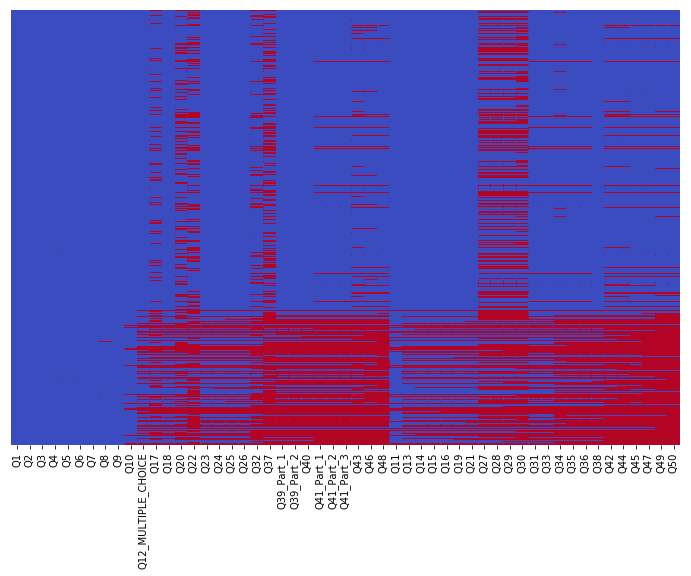

In [29]:
# new data frame with all the combined columns
cat_encoded = pd.concat([Q11_combined, Q13_combined, Q14_combined, Q15_combined, Q16_combined, Q19_combined, Q21_combined, Q27_combined, Q28_combined, Q29_combined, Q30_combined, Q31_combined, Q33_combined, Q34_combined, Q35_combined, Q36_combined, Q38_combined, Q42_combined, Q44_combined, Q45_combined, Q47_combined, Q49_combined, Q50_combined],axis=1)
cat_encoded.columns = ['Q11','Q13','Q14','Q15','Q16','Q19','Q21','Q27','Q28','Q29','Q30','Q31','Q33','Q34','Q35','Q36','Q38','Q42','Q44','Q45','Q47','Q49','Q50']
# new data frame with all the ones that were made dummy
dummy_encoded = pd.concat([data['Q1'],data['Q2'],data['Q3'],data['Q4'],data['Q5'],data['Q6'],data['Q7'],data['Q8'],data['Q9'],data['Q10'],data['Q12_MULTIPLE_CHOICE'],data['Q17'],data['Q18'],data['Q20'],data['Q22'],data['Q23'],data['Q24'],data['Q25'],data['Q26'],data['Q32'],data['Q37'],data['Q39_Part_1'],data['Q39_Part_2'],data['Q40'],data['Q41_Part_1'],data['Q41_Part_2'],data['Q41_Part_3'],data['Q43'],data['Q46'],data['Q48']], axis=1)
# Check missing values from the whole encoded data set
encoded_all = pd.concat([dummy_encoded, cat_encoded], axis=1)
# plot nan
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(encoded_all.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

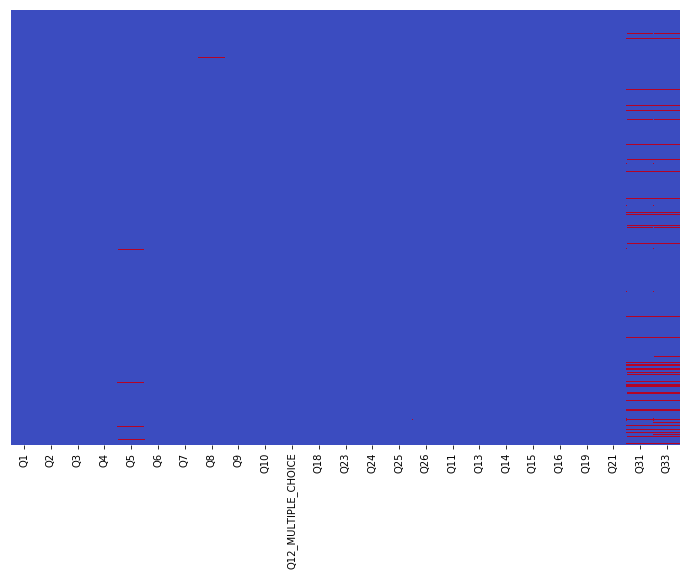

In [33]:
# first drop columns(features) that have more than 20% missing data
encoded_col_dropped = drop_col(encoded_all, 20)
# then drop entries with more than 20% missing data
encoded_dropped = drop_row(encoded_col_dropped, 20)
# plot
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(encoded_dropped.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

In [34]:
encoded_dropped.isnull().sum()

Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                       89
Q6                        0
Q7                        0
Q8                       62
Q9                        0
Q10                       0
Q12_MULTIPLE_CHOICE       0
Q18                       0
Q23                       0
Q24                      20
Q25                      46
Q26                      55
Q11                       0
Q13                       0
Q14                       0
Q15                       0
Q16                       0
Q19                       0
Q21                       0
Q31                    1043
Q33                    1117
dtype: int64

##### Q5: Undergraduate/College Major

In [35]:
# there are 89 missing values
Q5_missing = encoded_dropped[encoded_dropped['Q5'].isnull()]
# 100% of people who didn't answer undergraduate/college major only completed secondary school
Q5_missing.Q4.value_counts(normalize=True)

Secondary School    1.0
Name: Q4, dtype: float64

In [36]:
# fill those nan values with a new category
data['Q5'] = data['Q5'].fillna('Secondary School Only')

In [37]:
data['Q5'].isna().sum()

0

##### Q8: How many years of experience in current role?

In [38]:
# there are 89 missing values
Q8_missing = encoded_dropped[encoded_dropped['Q8'].isnull()]
# 85% of people who did not answer YOE are currently students
Q8_missing.Q6.value_counts(normalize=True)

Student           0.854839
Analyst           0.096774
Researcher        0.016129
Consultant        0.016129
Data Scientist    0.016129
Name: Q6, dtype: float64

In [39]:
# 90% of people who did not answer YOE are between 18-29 years of age
Q8_missing.Q2.value_counts(normalize=True)

18-24    0.661290
25-34    0.290323
45-54    0.032258
35-44    0.016129
Name: Q2, dtype: float64

In [40]:
# Approximately 84% of students who are also under 35 list 0-5 years for YOE
under_thirty = data.loc[data['Q2'].isin(['18-24','25-34'])]
students_under_thirty = under_thirty.loc[data['Q6'].isin(['Student'])]
students_under_thirty.Q8.value_counts(normalize=True)

0-5      0.858990
10-20    0.087677
5-10     0.046869
20+      0.006465
Name: Q8, dtype: float64

In [41]:
# fill those nan values with 0-5 YOE
data['Q8'] = data['Q8'].fillna('0-5')

##### Q24: How long have you been writing code to analyze data

In [42]:
# there are 20 missing values
Q24_missing = encoded_dropped[encoded_dropped['Q24'].isnull()]
# 85% of people who did not answer have Master's or Other degrees
Q24_missing.Q4.value_counts(normalize=True)

Other                  0.45
Master’s degree        0.40
Doctoral degree        0.10
Professional degree    0.05
Name: Q4, dtype: float64

In [43]:
# since the mode is 1-2 years
data.Q24.mode()

0    1-2 years
dtype: object

In [44]:
# fill those nan values with 0-3 YOE
data['Q24'] = data['Q24'].fillna('1-2 years')

##### Q25: How many years have you used ML methods?

In [45]:
# there are 46 missing values
Q25_missing = encoded_dropped[encoded_dropped['Q25'].isnull()]
# Only 9% of people who did not answer are students, implying the rest are working
Q25_missing.Q6.value_counts(normalize=True)

Data Scientist       0.217391
Software Engineer    0.217391
Other                0.130435
Analyst              0.130435
Student              0.086957
Researcher           0.086957
Consultant           0.065217
Leader               0.065217
Name: Q6, dtype: float64

In [46]:
# 65% of current employers of those who did not answer years of ML use are not well established in ML methods
Q25_missing.Q10.value_counts(normalize=True)

We are exploring ML methods (and may one day put a model into production)                    0.282609
No (we do not use ML methods)                                                                0.217391
We have well established ML methods (i.e., models in production for more than 2 years)       0.173913
We recently started using ML methods (i.e., models in production for less than 2 years)      0.152174
I do not know                                                                                0.108696
We use ML methods for generating insights (but do not put working models into production)    0.065217
Name: Q10, dtype: float64

In [47]:
not_familiar = data.loc[data['Q10'].isin(['We are exploring ML methods (and may one day put a model into production)','No (we do not use ML methods)', 'We recently started using ML methods (i.e., models in production for less than 2 years)'])]
# 95% of people who work in companies not familiar with ML listed ML experience as between 0-5 years
not_familiar.Q25.value_counts(normalize=True)

0-5    0.94566
5+     0.05434
Name: Q25, dtype: float64

In [48]:
# fill those nan values with 0-5 years of ML experience
data['Q25'] = data['Q25'].fillna('0-5')

##### Q26: Do you consider yourself to be a data scientist?

In [49]:
# there are 55 missing values
Q26_missing = encoded_dropped[encoded_dropped['Q26'].isnull()]
Q26_missing.Q6.value_counts(normalize=True)

Analyst              0.200000
Software Engineer    0.200000
Data Scientist       0.181818
Other                0.127273
Student              0.090909
Researcher           0.072727
Leader               0.072727
Consultant           0.054545
Name: Q6, dtype: float64

In [50]:
DS_title = data.loc[data['Q6'].isin(['Data Scientist'])]
# 89% of people who has a title of Data Scientist considers themselves as Data Scientists
DS_title['Q26'].value_counts(normalize=True)

Yes      0.891086
Maybe    0.089477
No       0.019437
Name: Q26, dtype: float64

In [51]:
NotDS_title = data.loc[~data['Q6'].isin(['Data Scientist'])]
# the mode of people who are not data scientists have also consider themselves as data scientists
NotDS_title['Q26'].mode()

0    Yes
dtype: object

In [52]:
# only 25% people are certain they are not data scientists
data['Q26'].value_counts(normalize=True)

Yes      0.534164
No       0.251828
Maybe    0.214009
Name: Q26, dtype: float64

In [53]:
# fill those nan values yes
data['Q26'] = data['Q26'].fillna('Yes')

#### Q31: Which type of data do you currently interact with most often at work?

In [54]:
# get the percentage of each part
Q31P1 = data['Q31_Part_1'].value_counts(normalize=True).tolist()
Q31P2 = data['Q31_Part_2'].value_counts(normalize=True).tolist()
Q31P3 = data['Q31_Part_3'].value_counts(normalize=True).tolist()
Q31P4 = data['Q31_Part_4'].value_counts(normalize=True).tolist()
Q31P5 = data['Q31_Part_5'].value_counts(normalize=True).tolist()
Q31P6 = data['Q31_Part_6'].value_counts(normalize=True).tolist()
Q31P7 = data['Q31_Part_7'].value_counts(normalize=True).tolist()
Q31P8 = data['Q31_Part_8'].value_counts(normalize=True).tolist()
Q31P9 = data['Q31_Part_9'].value_counts(normalize=True).tolist()
Q31P10 = data['Q31_Part_10'].value_counts(normalize=True).tolist()
Q31P11 = data['Q31_Part_11'].value_counts(normalize=True).tolist()
Q31P12 = data['Q31_Part_12'].value_counts(normalize=True).tolist()
# Create a dictionary with the percentage of people working with each kinds of data
dict_Q31 = {'Audio:': Q31P1[0], 'Categorical:': Q31P2[0], 'Genetic:':Q31P3[0], 'Geospatial:':Q31P4[0], 'Image:':Q31P5[0], 'Numerical':Q31P6[0], 'Sensor:':Q31P7[0], 'Tabular:':Q31P8[0], 'Text:':Q31P9[0], 'Time:':Q31P10[0],'Video:':Q31P11[0],'Other:':Q31P12[0]}
# Audio (1), Genetic (3), Other(12) and Video(11) all have above 90%
dict_Q31

{'Audio:': 0.9564456542873809,
 'Categorical:': 0.6004925789098451,
 'Genetic:': 0.9489273446107979,
 'Geospatial:': 0.8845680212586687,
 'Image:': 0.75701600881457,
 'Numerical': 0.5315315315315315,
 'Other:': 0.9806857216929159,
 'Sensor:': 0.8772441506254456,
 'Tabular:': 0.6346490375267354,
 'Text:': 0.5819560567762007,
 'Time:': 0.612677425627066,
 'Video:': 0.9364832458357638}

In [55]:
# takes 10 min to run
# fill Part 1, Part 3, Part 7 and Part 12 with 1 for the NaN values
Q31_nan_row_index = Q31_combined.index[Q31_combined.isna()].tolist()
iteration = 1
for i in Q31_nan_row_index:
    data['Q31_Part_1'].loc[i]=1
    data['Q31_Part_3'].loc[i]=1
    data['Q31_Part_11'].loc[i]=1
    data['Q31_Part_12'].loc[i]=1
    percent_complete = round((iteration/len(Q31_nan_row_index))*100,2)
    clear_output(wait=True)
    iteration = iteration + 1
    print('Complete: ' + str(percent_complete) + '%')

Complete: 100.0%


#### Q33: Where do you find public data sets

In [56]:
# get the percentage of each part
Q33P1 = data['Q33_Part_1'].value_counts(normalize=True).tolist()
Q33P2 = data['Q33_Part_2'].value_counts(normalize=True).tolist()
Q33P3 = data['Q33_Part_3'].value_counts(normalize=True).tolist()
Q33P4 = data['Q33_Part_4'].value_counts(normalize=True).tolist()
Q33P5 = data['Q33_Part_5'].value_counts(normalize=True).tolist()
Q33P6 = data['Q33_Part_6'].value_counts(normalize=True).tolist()
Q33P7 = data['Q33_Part_7'].value_counts(normalize=True).tolist()
Q33P8 = data['Q33_Part_8'].value_counts(normalize=True).tolist()
Q33P9 = data['Q33_Part_9'].value_counts(normalize=True).tolist()
Q33P10 = data['Q33_Part_10'].value_counts(normalize=True).tolist()
Q33P11 = data['Q33_Part_11'].value_counts(normalize=True).tolist()
# Create a dictionary with the percentage of people working with each kinds of data
dict_Q33 = {'Government:': Q33P1[0], 'University Research:': Q33P2[0], 'Non Profit Research:':Q33P3[0], 'Dataset Aggregator:':Q33P4[0], 'Own:':Q33P5[0], 'Public Release from Private Company':Q33P6[0], 'Google Search:':Q33P7[0], 'Google Dataset Search:':Q33P8[0], 'GitHub:':Q33P9[0], 'None:':Q33P10[0],'Other:':Q31P11[0]}
# Other(8) have above 90%
dict_Q33

{'Dataset Aggregator:': 0.620195735303649,
 'GitHub:': 0.7183226391859485,
 'Google Dataset Search:': 0.8312917233780543,
 'Google Search:': 0.6668611057100265,
 'Government:': 0.7638213753321667,
 'Non Profit Research:': 0.8656426210383045,
 'None:': 0.8958454857735433,
 'Other:': 0.9364832458357638,
 'Own:': 0.7413960723313241,
 'Public Release from Private Company': 0.8532633352777238,
 'University Research:': 0.8040054442932141}

In [57]:
Q33_nan_row_index = Q33_combined.index[Q33_combined.isna()].tolist()
iteration = 1
for i in Q33_nan_row_index:
    data['Q33_Part_11'].loc[i]=1
    percent_complete = round((iteration/len(Q33_nan_row_index))*100,2)
    clear_output(wait=True)
    iteration = iteration + 1
    print('Complete: ' + str(percent_complete) + '%')

Complete: 100.0%


### Cleaned Data

In [72]:
Q1_dummies = dummy('Q1')
Q2_dummies = dummy('Q2')
Q3_dummies = dummy('Q3')
Q4_dummies = dummy('Q4')
Q5_dummies = dummy('Q5')
Q6_dummies = dummy('Q6')
Q7_dummies = dummy('Q7')
Q8_dummies = dummy('Q8')
Q10_dummies = dummy('Q10')
Q12_dummies = dummy('Q12_MULTIPLE_CHOICE')
#Q17_dummies = dummy('Q17')
Q18_dummies = dummy('Q18')
#Q20_dummies = dummy('Q20')
#Q22_dummies = dummy('Q22')
Q23_dummies = dummy('Q23')
Q24_dummies = dummy('Q24')
Q25_dummies = dummy('Q25')
Q26_dummies = dummy('Q26')
#Q32_dummies = dummy('Q32')
#Q37_dummies = dummy('Q37')
#Q39P1_dummies = dummy('Q39_Part_1')
#Q39P2_dummies = dummy('Q39_Part_2')
#Q40_dummies = dummy('Q40')
#Q41P1_dummies = dummy('Q41_Part_1')
#Q41P2_dummies = dummy('Q41_Part_2')
#Q41P3_dummies = dummy('Q41_Part_3')
#Q43_dummies = dummy('Q43')
#Q46_dummies = dummy('Q46')
#Q48_dummies = dummy('Q48')

In [76]:
# concatenate all dummy data
dummy_data = pd.concat([Q1_dummies, Q2_dummies, Q3_dummies, Q4_dummies, Q5_dummies, Q6_dummies, Q7_dummies, Q8_dummies, Q10_dummies, Q12_dummies, Q18_dummies, Q23_dummies, Q24_dummies, Q25_dummies, Q26_dummies], axis=1)
# drop any column with "TEXT" in title
data.drop([col for col in data.columns if 'TEXT' in col],axis=1,inplace=True)
# drop other unecessary columns
 data.drop(['Unnamed: 0', 'Time from Start to Finish (seconds)', 'index', 'Salary_label'], axis=1, inplace=True)
# drop the non-encoded columns
data.drop(['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q10','Q12_MULTIPLE_CHOICE','Q18','Q23','Q24','Q25','Q26'], axis=1, inplace=True)
# form cleaned data
cleaned_data = pd.concat([dummy_data, data], axis=1)

### Feature Selection

In [79]:
X = cleaned_data.drop(['Q9'],axis=1)
y = cleaned_data['Q9']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [48]:
# clf = linear_model.Lasso(alpha=0.1)
# clf.fit(X_train, y_train)

In [49]:
# scaler = StandardScaler()
# scaler.fit(X_train.fillna(0))

In [80]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(X_train, y_train)

/home/aaron/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aaron/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='warn',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [81]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [82]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 226
selected features: 226
features with coefficients shrank to zero: 1230


In [54]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

IndexError: boolean index did not match indexed array along dimension 0; dimension is 595 but corresponding boolean dimension is 10710

### Logistic Regression

In [43]:
X = cleaned_data.drop(['Q9'],axis=1)
y = cleaned_data['Q9']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [45]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
model = LogisticRegression()    
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.784%
Fold 2: Accuracy: 0.73%
Fold 3: Accuracy: 0.711%
Fold 4: Accuracy: 0.747%
Fold 5: Accuracy: 0.75%
Fold 6: Accuracy: 0.746%
Fold 7: Accuracy: 0.771%
Fold 8: Accuracy: 0.767%
Fold 9: Accuracy: 0.737%
Fold 10: Accuracy: 0.772%
Average Score: 75.161%(2.114%)
